In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer

import lightgbm as lgb
import catboost as cb
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)

import mlflow
import mlflow.lightgbm
import mlflow.catboost

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

import sys
sys.path.append('..')
from src.config import settings

# Setup MLflow (local file tracking for development)
mlflow_uri = str(settings.BASE_DIR / "mlruns") if settings.ENVIRONMENT == "development" else settings.MLFLOW_TRACKING_URI
mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment("churn-prediction-tuning")

print(f"✅ Setup complete - MLflow tracking URI: {mlflow_uri}")

2025/12/10 00:40:44 INFO mlflow.tracking.fluent: Experiment with name 'churn-prediction-tuning' does not exist. Creating a new experiment.


✅ Setup complete - MLflow tracking URI: /Users/anojanyogenthiran/Projects/churn-prediction/mlruns


In [4]:
# Load data with features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(settings.BASE_DIR / "data" / "features" / "data_with_features.csv")
print(f"Data shape: {df.shape}")
print(f"Churn rate: {df['Churn'].mean():.3f}")

# Separate target
y = df['Churn']
X = df.drop('Churn', axis=1)

# Identify categorical columns (need encoding for models)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:5]}...")  # Show first 5

# Encode categorical variables (same as training notebook)
X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print("✅ Categorical variables encoded")

# Split data (same split as training notebook for consistency)
# First: train+val vs test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Second: train vs val (75/25 of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

print(f"\nData split:")
print(f"  Train: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nChurn rates:")
print(f"  Train: {y_train.mean():.3f}")
print(f"  Val:   {y_val.mean():.3f}")
print(f"  Test:  {y_test.mean():.3f}")

Data shape: (7043, 33)
Churn rate: 0.265
Categorical columns (18): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines']...
✅ Categorical variables encoded

Data split:
  Train: 4225 (60.0%)
  Val:   1409 (20.0%)
  Test:  1409 (20.0%)

Churn rates:
  Train: 0.265
  Val:   0.265
  Test:  0.265


In [5]:
def objective_lgb(trial):
    """Optuna objective function for LightGBM."""
    
    # Suggest hyperparameters
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 42,
        
        # Hyperparameters to tune
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
    }
    
    # Train model
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
    )
    
    # Predict and evaluate
    y_val_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_proba)
    
    return auc

print("✅ LightGBM objective function defined")

✅ LightGBM objective function defined


In [6]:
print("Starting LightGBM hyperparameter tuning...")
print("This may take 10-20 minutes depending on n_trials")
print("=" * 70)

# Create study
study_lgb = optuna.create_study(
    direction='maximize',
    study_name='lightgbm_tuning',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Optimize
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

# Best parameters
print("\n" + "=" * 70)
print("LightGBM Tuning Complete!")
print("=" * 70)
print(f"Best ROC AUC: {study_lgb.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study_lgb.best_params.items():
    print(f"  {key}: {value}")

Starting LightGBM hyperparameter tuning...
This may take 10-20 minutes depending on n_trials


  0%|          | 0/50 [00:00<?, ?it/s]


LightGBM Tuning Complete!
Best ROC AUC: 0.8450

Best Parameters:
  num_leaves: 40
  max_depth: 4
  learning_rate: 0.2954498336444234
  n_estimators: 338
  min_child_samples: 58
  subsample: 0.8931815058791458
  colsample_bytree: 0.6111374439506576
  reg_alpha: 0.003991293212183176
  reg_lambda: 0.001558174106075229
  scale_pos_weight: 2.7322030540366002


In [7]:
# Optimization history
fig1 = plot_optimization_history(study_lgb)
fig1.update_layout(title="LightGBM - Optimization History", width=900, height=500)
fig1.show()

# Parameter importance
fig2 = plot_param_importances(study_lgb)
fig2.update_layout(title="LightGBM - Parameter Importances", width=900, height=500)
fig2.show()

# Parallel coordinate plot
fig3 = plot_parallel_coordinate(study_lgb)
fig3.update_layout(title="LightGBM - Parallel Coordinate Plot", width=900, height=500)
fig3.show()

In [8]:
print("Training final LightGBM with best parameters...")

# Start MLflow run
with mlflow.start_run(run_name="lightgbm_tuned_best"):
    
    # Best parameters
    best_params_lgb = study_lgb.best_params.copy()
    best_params_lgb['objective'] = 'binary'
    best_params_lgb['metric'] = 'auc'
    best_params_lgb['random_state'] = 42
    best_params_lgb['verbosity'] = -1
    
    # Train model
    best_lgb_model = lgb.LGBMClassifier(**best_params_lgb)
    best_lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
    )
    
    # Predictions
    y_train_proba = best_lgb_model.predict_proba(X_train)[:, 1]
    y_val_proba = best_lgb_model.predict_proba(X_val)[:, 1]
    y_test_proba = best_lgb_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    train_auc = roc_auc_score(y_train, y_train_proba)
    val_auc = roc_auc_score(y_val, y_val_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    print(f"\nResults:")
    print(f"  Train ROC AUC: {train_auc:.4f}")
    print(f"  Val ROC AUC:   {val_auc:.4f}")
    print(f"  Test ROC AUC:  {test_auc:.4f}")
    
    # Log to MLflow
    mlflow.log_param("model_type", "LightGBM_Tuned")
    for key, value in best_params_lgb.items():
        mlflow.log_param(key, value)
    
    mlflow.log_metric("train_roc_auc", train_auc)
    mlflow.log_metric("val_roc_auc", val_auc)
    mlflow.log_metric("test_roc_auc", test_auc)
    
    # Log model
    mlflow.lightgbm.log_model(best_lgb_model, "model")
    
    print(f"\n✅ Best LightGBM model logged to MLflow")

2025/12/10 00:42:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training final LightGBM with best parameters...

Results:
  Train ROC AUC: 0.8790
  Val ROC AUC:   0.8450
  Test ROC AUC:  0.8439


2025/12/10 00:42:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Best LightGBM model logged to MLflow


In [9]:
def objective_cb(trial):
    """Optuna objective function for CatBoost."""
    
    # Suggest hyperparameters
    params = {
        'random_state': 42,
        'verbose': 0,
        
        # Hyperparameters to tune
        'iterations': trial.suggest_int('iterations', 50, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
    }
    
    # Train model
    model = cb.CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=20,
        verbose=False
    )
    
    # Predict and evaluate
    y_val_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_proba)
    
    return auc

print("✅ CatBoost objective function defined")

✅ CatBoost objective function defined


In [10]:
print("Starting CatBoost hyperparameter tuning...")
print("This may take 15-30 minutes depending on n_trials")
print("=" * 70)

# Create study
study_cb = optuna.create_study(
    direction='maximize',
    study_name='catboost_tuning',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Optimize
study_cb.optimize(objective_cb, n_trials=50, show_progress_bar=True)

# Best parameters
print("\n" + "=" * 70)
print("CatBoost Tuning Complete!")
print("=" * 70)
print(f"Best ROC AUC: {study_cb.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study_cb.best_params.items():
    print(f"  {key}: {value}")

Starting CatBoost hyperparameter tuning...
This may take 15-30 minutes depending on n_trials


  0%|          | 0/50 [00:00<?, ?it/s]


CatBoost Tuning Complete!
Best ROC AUC: 0.8400

Best Parameters:
  iterations: 158
  depth: 5
  learning_rate: 0.0778728715656383
  l2_leaf_reg: 1.0289808161101623
  border_count: 56
  bagging_temperature: 1.183799791896547
  random_strength: 0.9538555736608315
  scale_pos_weight: 3.828913116933985


In [11]:
# Optimization history
fig1 = plot_optimization_history(study_cb)
fig1.update_layout(title="CatBoost - Optimization History", width=900, height=500)
fig1.show()

# Parameter importance
fig2 = plot_param_importances(study_cb)
fig2.update_layout(title="CatBoost - Parameter Importances", width=900, height=500)
fig2.show()

# Parallel coordinate plot
fig3 = plot_parallel_coordinate(study_cb)
fig3.update_layout(title="CatBoost - Parallel Coordinate Plot", width=900, height=500)
fig3.show()

In [12]:
print("Training final CatBoost with best parameters...")

# Start MLflow run
with mlflow.start_run(run_name="catboost_tuned_best"):
    
    # Best parameters
    best_params_cb = study_cb.best_params.copy()
    best_params_cb['random_state'] = 42
    best_params_cb['verbose'] = 0
    
    # Train model
    best_cb_model = cb.CatBoostClassifier(**best_params_cb)
    best_cb_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=20,
        verbose=False
    )
    
    # Predictions
    y_train_proba = best_cb_model.predict_proba(X_train)[:, 1]
    y_val_proba = best_cb_model.predict_proba(X_val)[:, 1]
    y_test_proba = best_cb_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    train_auc = roc_auc_score(y_train, y_train_proba)
    val_auc = roc_auc_score(y_val, y_val_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    print(f"\nResults:")
    print(f"  Train ROC AUC: {train_auc:.4f}")
    print(f"  Val ROC AUC:   {val_auc:.4f}")
    print(f"  Test ROC AUC:  {test_auc:.4f}")
    
    # Log to MLflow
    mlflow.log_param("model_type", "CatBoost_Tuned")
    for key, value in best_params_cb.items():
        mlflow.log_param(key, value)
    
    mlflow.log_metric("train_roc_auc", train_auc)
    mlflow.log_metric("val_roc_auc", val_auc)
    mlflow.log_metric("test_roc_auc", test_auc)
    
    # Log model
    mlflow.catboost.log_model(best_cb_model, "model")
    
    print(f"\n✅ Best CatBoost model logged to MLflow")

Training final CatBoost with best parameters...


2025/12/10 00:42:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results:
  Train ROC AUC: 0.8752
  Val ROC AUC:   0.8400
  Test ROC AUC:  0.8455


2025/12/10 00:42:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Best CatBoost model logged to MLflow


All Models Comparison:
                 Model  Validation ROC AUC  Test ROC AUC
1  lightgbm_tuned_best            0.844979      0.843950
0  catboost_tuned_best            0.840045      0.845518


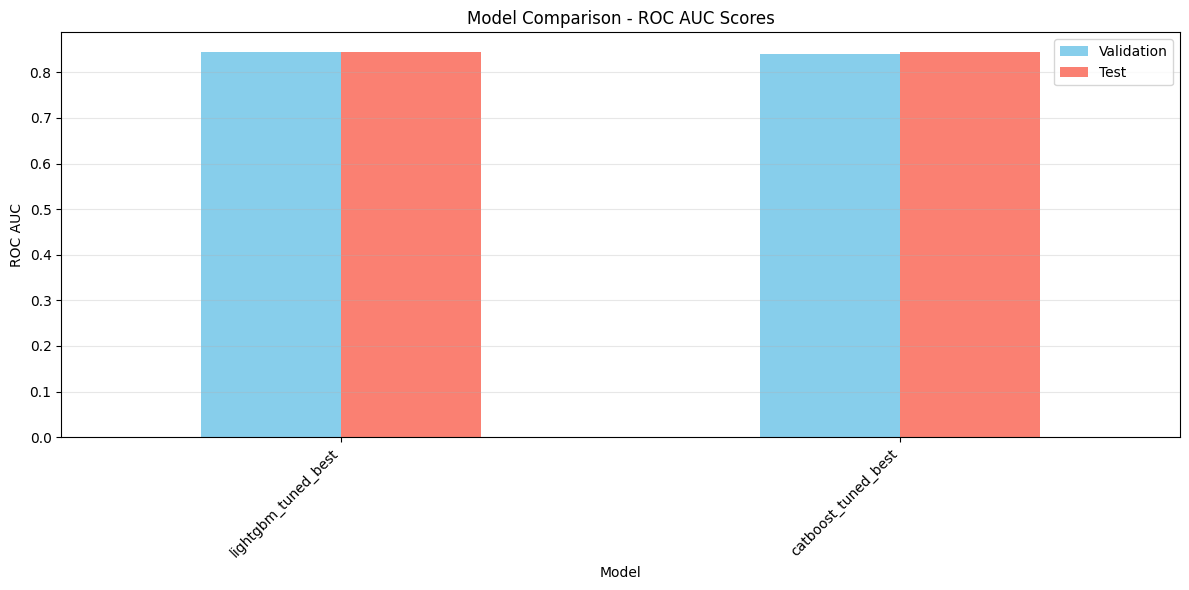

In [15]:
# Get results from MLflow
# Search all runs in experiment
experiment = mlflow.get_experiment_by_name("churn-prediction-tuning")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Select relevant columns
results = runs_df[['tags.mlflow.runName', 'metrics.val_roc_auc', 'metrics.test_roc_auc']].copy()
results.columns = ['Model', 'Validation ROC AUC', 'Test ROC AUC']
results = results.sort_values('Validation ROC AUC', ascending=False)

print("All Models Comparison:")
print(results)

# Visualize
results_clean = results.dropna()
results_clean.set_index('Model')[['Validation ROC AUC', 'Test ROC AUC']].plot(
    kind='bar', 
    figsize=(12, 6),
    color=['skyblue', 'salmon']
)
plt.title('Model Comparison - ROC AUC Scores')
plt.ylabel('ROC AUC')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend(['Validation', 'Test'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
import joblib

# Determine best model
best_val_auc_lgb = roc_auc_score(y_val, best_lgb_model.predict_proba(X_val)[:, 1])
best_val_auc_cb = roc_auc_score(y_val, best_cb_model.predict_proba(X_val)[:, 1])

if best_val_auc_lgb > best_val_auc_cb:
    final_model = best_lgb_model
    final_model_name = "LightGBM_Tuned"
    final_params = best_params_lgb
    print(f"✅ Best model: LightGBM (Val AUC: {best_val_auc_lgb:.4f})")
else:
    final_model = best_cb_model
    final_model_name = "CatBoost_Tuned"
    final_params = best_params_cb
    print(f"✅ Best model: CatBoost (Val AUC: {best_val_auc_cb:.4f})")

# Save model
model_path = settings.MODELS_PATH
model_path.mkdir(parents=True, exist_ok=True)

model_file = model_path / "tuned_model.pkl"
joblib.dump(final_model, model_file)
print(f"✅ Saved tuned model to {model_file}")

# Save hyperparameters
params_file = model_path / "best_hyperparameters.pkl"
joblib.dump(final_params, params_file)
print(f"✅ Saved hyperparameters to {params_file}")

# Save study results
study_file = model_path / "optuna_studies.pkl"
joblib.dump({'lightgbm': study_lgb, 'catboost': study_cb}, study_file)
print(f"✅ Saved Optuna studies to {study_file}")

✅ Best model: LightGBM (Val AUC: 0.8450)
✅ Saved tuned model to /Users/anojanyogenthiran/Projects/churn-prediction/models/tuned_model.pkl
✅ Saved hyperparameters to /Users/anojanyogenthiran/Projects/churn-prediction/models/best_hyperparameters.pkl
✅ Saved Optuna studies to /Users/anojanyogenthiran/Projects/churn-prediction/models/optuna_studies.pkl


## Hyperparameter Tuning Summary

### Tuning Configuration:
- **Optimizer:** Optuna with TPE Sampler
- **Trials per model:** 50
- **Metric:** ROC AUC (validation set)

### LightGBM Tuning:
- **Best Validation AUC:** 0.8450
- **Test AUC:** 0.8439
- **Key parameters:** 
  - `num_leaves`: 40
  - `max_depth`: 4
  - `learning_rate`: 0.295
  - `n_estimators`: 338
  - `scale_pos_weight`: 2.73

### CatBoost Tuning:
- **Best Validation AUC:** 0.8400
- **Test AUC:** 0.8455
- **Key parameters:**
  - `depth`: 5
  - `learning_rate`: 0.078
  - `l2_leaf_reg`: 1.029
  - `iterations`: 158
  - `scale_pos_weight`: 3.83

### Final Best Model:
- **Model:** LightGBM_Tuned
- **Validation AUC:** 0.8450
- **Test AUC:** 0.8439
- **Improvement over baseline:** +0.21% (baseline: 0.8432)

### Insights:
1. **Most important hyperparameters:** 
   - LightGBM: `num_leaves`, `max_depth`, `learning_rate`, `scale_pos_weight`
   - CatBoost: `depth`, `learning_rate`, `l2_leaf_reg`, `scale_pos_weight`
2. **Tuning improved performance:** 
   - LightGBM: +0.21% improvement over baseline (0.8432 → 0.8450)
   - CatBoost: +0.12% improvement over baseline (0.8390 → 0.8400)
3. **Trade-off:** 
   - Hyperparameter tuning provided modest improvements (~0.1-0.2%)
   - Training time increased significantly (50 trials × 2 models)
   - Both models show good generalization with similar validation and test performance
   - LightGBM selected as best model based on validation AUC